In [76]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
import requests
import re
import urllib.request
from bs4 import BeautifulSoup
from collections import deque
from html.parser import HTMLParser
from urllib.parse import urlparse
import threading
import os
import time
from timeit import default_timer as timer

# Regex pattern to match a URL
HTTP_URL_PATTERN = r'^http[s]*://.+'

# Define root domain to crawl
domain = "openai.com"
full_url = "https://openai.com/"
set_lock = threading.Lock()
NUM_THREADS = 10

In [77]:


# Create a class to parse the HTML and get the hyperlinks
class HyperlinkParser(HTMLParser):
    def __init__(self):
        super().__init__()
        # Create a list to store the hyperlinks
        self.hyperlinks = []

    # Override the HTMLParser's handle_starttag method to get the hyperlinks
    def handle_starttag(self, tag, attrs):
        attrs = dict(attrs)

        # If the tag is an anchor tag and it has an href attribute, add the href attribute to the list of hyperlinks
        if tag == "a" and "href" in attrs:
            self.hyperlinks.append(attrs["href"])

# Function to get the hyperlinks from a URL
def get_hyperlinks(url):
    
    # Try to open the URL and read the HTML
    try:
        # Open the URL and read the HTML
        with urllib.request.urlopen(url) as response:

            # If the response is not HTML, return an empty list
            if not response.info().get('Content-Type').startswith("text/html"):
                return []
            
            # Decode the HTML
            html = response.read().decode('utf-8')
    except Exception as e:
        print(e)
        return []

    # Create the HTML Parser and then Parse the HTML to get hyperlinks
    parser = HyperlinkParser()
    parser.feed(html)

    return parser.hyperlinks

# Function to get the hyperlinks from a URL that are within the same domain
def get_domain_hyperlinks(local_domain, url):
    clean_links = []
    for link in set(get_hyperlinks(url)):
        clean_link = None

        # If the link is a URL, check if it is within the same domain
        if re.search(HTTP_URL_PATTERN, link):
            # Parse the URL and check if the domain is the same
            url_obj = urlparse(link)
            if url_obj.netloc == local_domain:
                clean_link = link

        # If the link is not a URL, check if it is a relative link
        else:
            if link.startswith("/"):
                link = link[1:]
            elif link.startswith("#") or link.startswith("mailto:"):
                continue
            clean_link = "https://" + local_domain + "/" + link

        if clean_link is not None:
            if clean_link.endswith("/"):
                clean_link = clean_link[:-1]
            clean_links.append(clean_link)

    # Return the list of hyperlinks that are within the same domain
    return list(set(clean_links))



local_domain = urlparse(full_url).netloc
queue = deque([full_url])
seen = set([full_url])

def crawl():
    # Parse the URL and get the domain
    
    # Create a queue to store the URLs to crawl
    # Create a set to store the URLs that have already been seen (no duplicates)
    

    # Create a directory to store the text files
    if not os.path.exists("text/"):
            os.mkdir("text/")

    if not os.path.exists("text/"+local_domain+"/"):
            os.mkdir("text/" + local_domain + "/")

    # Create a directory to store the csv files
    if not os.path.exists("processed"):
            os.mkdir("processed")

    # While the queue is not empty, continue crawling
    sleep_count = 0
    while sleep_count < 10:
        if queue:
        # Get the next URL from the queue
            url = queue.pop()
            print(url) # for debugging and to see the progress
    
            # Save text from the url to a <url>.txt file
            with open('text/'+local_domain+'/'+url[8:].replace("/", "_") + ".txt", "w") as f:
    
                # Get the text from the URL using BeautifulSoup
                soup = BeautifulSoup(requests.get(url).text, "html.parser")
    
                # Get the text but remove the tags
                text = soup.get_text()
    
                # If the crawler gets to a page that requires JavaScript, it will stop the crawl
                if ("You need to enable JavaScript to run this app." in text):
                    print("Unable to parse page " + url + " due to JavaScript being required")
                
                # Otherwise, write the text to the file in the text directory
                f.write(text)
    
            # Get the hyperlinks from the URL and add them to the queue
            with set_lock:
                for link in get_domain_hyperlinks(local_domain, url):
                    if link not in seen:
                        queue.append(link)
                        seen.add(link)
        else:
            sleep_count += 1
            time.sleep(0.1)
            
            
def crawl_multithreaded():
    threads = [threading.Thread(target = crawl) for i in range(NUM_THREADS)]
    
    for thread in threads:
        thread.start()
    
    
    for thread in threads:
        thread.join()
 
start = timer()
# crawl_multithreaded()
end = timer()




In [117]:
def remove_newlines(serie):
    serie = serie.str.replace('\n', ' ')
    serie = serie.str.replace('\\n', ' ')
    serie = serie.str.replace('  ', ' ')
    serie = serie.str.replace('  ', ' ')
    return serie

In [118]:

import pandas as pd

# Create a list to store the text files
texts=[]

# Get all the text files in the text directory
for file in os.listdir("text/" + domain + "/"):

    # Open the file and read the text
    with open("text/" + domain + "/" + file, "r") as f:
        text = f.read()

        # Omit the first 11 lines and the last 4 lines, then replace -, _, and #update with spaces.
        texts.append((file[11:-4].replace('-',' ').replace('_', ' ').replace('#update',''), text))

# Create a dataframe from the list of texts
df = pd.DataFrame(texts, columns = ['fname', 'text'])

# Set the text column to be the raw text with the newlines removed
df['text'] = df.fname + ". " + remove_newlines(df.text)
df.to_csv('processed/scraped.csv')
df.head()

/var/folders/99/632bmz5x25b69wx8751r54dh0000gn/T/ipykernel_43242/2931785837.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  serie = serie.str.replace('\\n', ' ')


,fname,text
0,careers research scientist safety#content,careers research scientist safety#content. Re...
1,research?authors=henk tillman,research?authors=henk tillman. Research index...
2,research?authors=arthur petron,research?authors=arthur petron. Research inde...
3,dall e 3#content,dall e 3#content. DALL·E 3 CloseSearch Subm...
4,policies service credit terms,policies service credit terms. Service credit...


<AxesSubplot: >

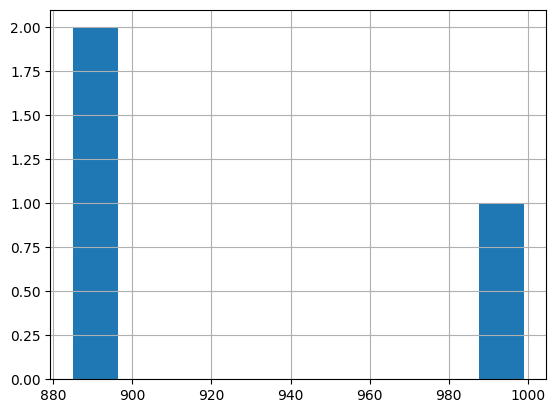

In [124]:
import tiktoken

# Load the cl100k_base tokenizer which is designed to work with the ada-002 model
tokenizer = tiktoken.get_encoding("cl100k_base")

df = pd.read_csv('processed/scraped.csv', index_col=0)
df.columns = ['title', 'text']

# Tokenize the text and save the number of tokens to a new column
df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))

# VisualizAxesSubplote the distribution of the number of tokens per row using a histogram
df.n_tokens.hist()

In [125]:
max_tokens = 500

# Function to split the text into chunks of a maximum number of tokens
def split_into_many(text, max_tokens = max_tokens):

    # Split the text into sentences
    sentences = text.split('. ')

    # Get the number of tokens for each sentence
    n_tokens = [len(tokenizer.encode(" " + sentence)) for sentence in sentences]
    
    chunks = []
    tokens_so_far = 0
    chunk = []

    # Loop through the sentences and tokens joined together in a tuple
    for sentence, token in zip(sentences, n_tokens):

        # If the number of tokens so far plus the number of tokens in the current sentence is greater 
        # than the max number of tokens, then add the chunk to the list of chunks and reset
        # the chunk and tokens so far
        if tokens_so_far + token > max_tokens:
            chunks.append(". ".join(chunk) + ".")
            chunk = []
            tokens_so_far = 0

        # If the number of tokens in the current sentence is greater than the max number of 
        # tokens, go to the next sentence
        if token > max_tokens:
            continue

        # Otherwise, add the sentence to the chunk and add the number of tokens to the total
        chunk.append(sentence)
        tokens_so_far += token + 1

    # Add the last chunk to the list of chunks
    if chunk:
        chunks.append(". ".join(chunk) + ".")

    return chunks
    

shortened = []

# Loop through the dataframe
for row in df.iterrows():

    # If the text is None, go to the next row
    if row[1]['text'] is None:
        continue

    # If the number of tokens is greater than the max number of tokens, split the text into chunks
    if row[1]['n_tokens'] > max_tokens:
        shortened += split_into_many(row[1]['text'])
    
    # Otherwise, add the text to the list of shortened texts
    else:
        shortened.append( row[1]['text'] )

<AxesSubplot: >

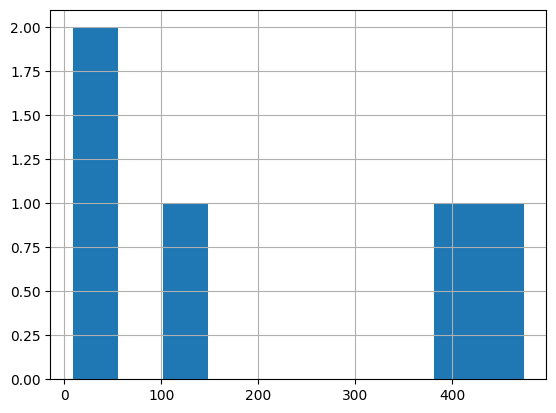

In [126]:
df = pd.DataFrame(shortened, columns = ['text'])
df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))
df.n_tokens.hist()

In [130]:
import os
import openai
import time

def init_api():
    with open(".env") as env:
        for line in env:
            key, value = line.strip().split("=")
            os.environ[key] = value

    openai.api_key = os.environ.get("API_KEY")
    openai.organization = os.environ.get("ORG_ID")

def generate_embeddings(text):
    while True:
        try:
            response = openai.Embedding.create(input=text, engine='text-embedding-ada-002')
            if 'data' in response and response['data']:
                return response['data'][0]['embedding']
            else:
                return None
        except openai.error.RateLimitError as e:
            wait_time = 20  # Default wait time in seconds
            if 'Retry-After' in e.headers:
                wait_time = int(e.headers['Retry-After'])
            print(f"Rate limit reached. Retrying in {wait_time} seconds...")
            time.sleep(wait_time)

def process_and_save_embeddings(df):
    embeddings = []
    for text in df['text']:
        embedding = generate_embeddings(text)
        if embedding:
            embeddings.append(embedding)
        else:
            embeddings.append(None)

    df['embeddings'] = embeddings
    df.to_csv('processed/embeddings.csv')
    df.head()

init_api()

# Assuming you have a DataFrame called 'df' with a 'text' column
# and you want to generate embeddings for each text and save them
# to a CSV file
process_and_save_embeddings(df)


Rate limit reached. Retrying in 20 seconds...
Rate limit reached. Retrying in 20 seconds...


In [131]:
import pandas as pd
import os
import numpy as np
from ast import literal_eval
from openai.embeddings_utils import distances_from_embeddings, cosine_similarity

df=pd.read_csv('processed/embeddings.csv', index_col=0)
df['embeddings'] = df['embeddings'].apply(literal_eval).apply(np.array)

df.head()

,text,n_tokens,embeddings
0,careers research scientist safety#content. Re...,474,"[-0.002279625041410327, -0.02433890663087368, ..."
1,"in computer science, machine learning, or a re...",392,"[-0.0001741664164001122, -0.03626922518014908,..."
2,Pursuant to the San Francisco Fair Chance Ordi...,134,"[0.009248313494026661, -0.020035723224282265, ..."
3,research?authors=henk tillman.,9,"[-0.006426393985748291, -0.020367804914712906,..."
4,research?authors=arthur petron.,9,"[-0.00471889041364193, -0.0065433862619102, -0..."


In [137]:
def call_openai_embedding_api(input_text):
    while True:
        try:
            # Make API call to get embeddings
            response = openai.Embedding.create(input=input_text, engine='text-embedding-ada-002')
            if 'data' in response and response['data']:
                return response['data'][0]['embedding']
            else:
                return None
        except openai.error.RateLimitError as e:
            wait_time = 20  # Default wait time in seconds
            if 'Retry-After' in e.headers:
                wait_time = int(e.headers['Retry-After'])
            print(f"Rate limit reached. Retrying in {wait_time} seconds...")
            time.sleep(wait_time)


def create_context(
    question, df, max_len=1800, size="ada"
):
    """
    Create a context for a question by finding the most similar context from the dataframe
    """

    # Get the embeddings for the question
    q_embeddings = call_openai_embedding_api(question)

    # Get the distances from the embeddings
    df['distances'] = distances_from_embeddings(q_embeddings, df['embeddings'].values, distance_metric='cosine')


    returns = []
    cur_len = 0

    # Sort by distance and add the text to the context until the context is too long
    for i, row in df.sort_values('distances', ascending=True).iterrows():
        
        # Add the length of the text to the current length
        cur_len += row['n_tokens'] + 4
        
        # If the context is too long, break
        if cur_len > max_len:
            break
        
        # Else add it to the text that is being returned
        returns.append(row["text"])

    # Return the context
    return "\n\n###\n\n".join(returns)

def answer_question(
    df,
    model="gpt-3.5-turbo-instruct",
    question="Am I allowed to publish model outputs to Twitter, without a human review?",
    max_len=1800,
    size="ada",
    debug=False,
    max_tokens=150,
    stop_sequence=None
):
    """
    Answer a question based on the most similar context from the dataframe texts
    """
    context = create_context(
        question,
        df,
        max_len=max_len,
        size=size,
    )
    # If debug, print the raw model response
    if debug:
        print("Context:\n" + context)
        print("\n\n")

    try:
        # Create a completions using the question and context
        response = openai.Completion.create(
            prompt=f"Answer the question based on the context below, and if the question can't be answered based on the context, say \"I don't know\"\n\nContext: {context}\n\n---\n\nQuestion: {question}\nAnswer:",
            temperature=0,
            max_tokens=max_tokens,
            top_p=1,
            frequency_penalty=0,
            presence_penalty=0,
            stop=stop_sequence,
            model=model,
        )
        return response["choices"][0]["text"].strip()
    except Exception as e:
        print(e)
        return ""
def init_api():
     with open(".env") as env:
         for line in env:
             key, value = line.strip().split("=")
             os.environ[key] = value

     openai.api_key = os.environ.get("API_KEY")
     openai.organization = os.environ.get("ORG_ID")
init_api()

In [133]:
answer_question(df, question="What day is it?", debug=False)

"I don't know."

In [140]:
answer_question(df, question="What is our newest embeddings model?")

"I don't know."

In [139]:
answer_question(df, question="What is ChatGPT?")

'ChatGPT is an API that allows users to interact with AI models through natural language conversations.'